In [29]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_nl import PatternTagger, PatternAnalyzer
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from loguru import logger
import matplotlib.dates as mdates
import click
from matplotlib.ticker import MultipleLocator
from statsmodels.nonparametric.smoothers_lowess import lowess

In [30]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': [],
 'logging': {'logdir': 'logs'}}

In [31]:
# Remove default logger and add console sink
logger.remove()
logger.add(sys.stderr, level="INFO")

# Get log directory from config
log_dir = Path(config["logging"]["logdir"]).resolve()
log_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Build timestamped logfile path
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logfile = log_dir / f"logfile-{timestamp}.log"

logfile = log_dir / f"logfile.log"

# Add file sink
logger.add(
    logfile,
    rotation="10 MB",
    retention="30 days",
    compression="zip",
    level="DEBUG",
    enqueue=True
)

10

In [32]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [33]:
df = pd.read_parquet(datafile)

In [34]:
# --- Step 1: Compute sentiment per message for all keywords, using NL analyzer/tagger ---
def compute_keyword_sentiment_nl(df, keywords):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Gebruik TextBlob-NL voor sentiment
    def sentiment_nl(text: str):
        blob = TextBlob(str(text), pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
        # TextBlobNL geeft blob.sentiment als een tuple (polarity, subjectivity)
        return blob.sentiment[0]  # pak polarity

    df["sentiment"] = df["message"].apply(sentiment_nl)

    for kw in keywords:
        # per bericht: of het keyword voorkomt → zo ja: sentiment, anders NaN
        df[kw] = df["message"].apply(
            lambda m: sentiment_nl(m) if kw.lower() in str(m).lower() else np.nan
        )

    return df[["timestamp", "message"] + keywords + ["sentiment"]]


# --- Step 2: Resample monthly to get mean sentiment per keyword ---
def resample_monthly_sentiment(df_keywords, keywords):
    df_keywords = df_keywords.set_index("timestamp")
    # For each keyword column calculate the monthly mean sentiment
    monthly_sentiment = df_keywords[keywords].resample("ME").mean()
    return monthly_sentiment


# --- Step 3: Filter months where all keywords appear (geen NaN voor deze maanden) ---
def filter_cooccurring_months(monthly_sentiment, keywords):
    filtered = monthly_sentiment.dropna(subset=keywords)
    return filtered


# --- Step 4: Get the actual messages where *alle* keywords co-occur in dezelfde message ---
def get_cooccurring_messages(df, keywords):
    mask = df[keywords].notna().all(axis=1)
    df_cooccur = df.loc[mask, ["timestamp", "message", "sentiment"]].copy()
    return df_cooccur


# def plot_cooccurring_keywords_rolling_only(monthly_sentiment, keywords):
#     plt.figure(figsize=(12, 6))

#     # Ensure tz-naive
#     monthly_sentiment.index = monthly_sentiment.index.tz_localize(None)

#     # Plot rolling mean per keyword
#     for kw in keywords:
#         series = monthly_sentiment[kw].dropna()
#         smoothed = series.rolling(window=3, min_periods=1, center=True).mean()
#         plt.plot(smoothed.index, smoothed.values, "-", linewidth=2, label=f"{kw} (rolling mean)")

#     # X-axis ticks
#     plt.xticks(monthly_sentiment.index, rotation=45)

#     # Formatting
#     plt.axhline(y=0, color="gray", linestyle="--", label="Neutraal sentiment")
#     plt.xlabel("Datum")
#     plt.ylabel("Gemiddeld sentiment (-1 negatief, +1 positief)")
#     plt.title(f"Sentiment trends voor keywords: {', '.join(keywords)} (rolling mean)")
#     plt.legend()
#     ax = plt.gca()
#     ax.yaxis.set_major_locator(MultipleLocator(0.02))
#     plt.tight_layout()
#     plt.show()

# def plot_cooccurring_keywords_rolling_only(monthly_sentiment, keywords):
#     plt.figure(figsize=(12, 6))

#     # Ensure tz-naive
#     monthly_sentiment.index = monthly_sentiment.index.tz_localize(None)

#     # Plot rolling mean per keyword
#     for kw in keywords:
#         series = monthly_sentiment[kw].dropna()
#         smoothed = series.rolling(window=3, min_periods=1, center=True).mean()
#         # plt.plot(smoothed.index, smoothed.values, "-", linewidth=2, label=f"{kw} (rolling mean)")
#         plt.plot(smoothed.index, smoothed.values, "-", linewidth=2, label=f"{kw}")

#     # Formatting
#     plt.axhline(y=0, color="gray", linestyle="--", label="Neutraal sentiment")
#     plt.xlabel("Datum")
#     plt.ylabel("Gemiddeld sentiment (-1 negatief, +1 positief)")
#     # plt.title(f"Sentiment trends voor keywords: {', '.join(keywords)} (rolling mean)")
#     plt.title(f"Sentiment trends over hygiëne en waardering in een flatgebouw!")
#     plt.legend()
#     ax = plt.gca()

#     # Set y-axis major ticks
#     ax.yaxis.set_major_locator(MultipleLocator(0.02))

#     # Set x-axis ticks every 3 months
#     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
#     plt.xticks(rotation=45)

#     plt.tight_layout()
#     plt.show()

def plot_cooccurring_keywords_rolling_only(monthly_sentiment, keywords):
    plt.figure(figsize=(12, 6))

    # Ensure tz-naive
    monthly_sentiment.index = monthly_sentiment.index.tz_localize(None)

    # Mapping for custom labels
    label_map = {
        "schoon": "Hygiëne",
        "dank": "Waardering"
    }

    # Plot rolling mean per keyword
    for kw in keywords:
        series = monthly_sentiment[kw].dropna()
        smoothed = series.rolling(window=3, min_periods=1, center=True).mean()
        plt.plot(
            smoothed.index, 
            smoothed.values, 
            "-", 
            linewidth=2, 
            label=f"{label_map.get(kw, kw)} (`{kw}`)"
        )

    # Formatting
    plt.axhline(y=0, color="gray", linestyle="--", label="Neutraal sentiment")
    plt.xlabel("Datum")
    plt.ylabel("Gemiddeld sentiment (-1 negatief, +1 positief)")
    plt.title("Sentiment trends over hygiëne en waardering in een flatgebouw!")
    plt.legend()
    ax = plt.gca()

    # Y-axis ticks
    ax.yaxis.set_major_locator(MultipleLocator(0.02))

    # X-axis ticks every 3 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# --- Example usage ---
# plot_cooccurring_keywords_rolling_only(monthly_sentiment, cooccurring_messages, ["schoon", "dank"])



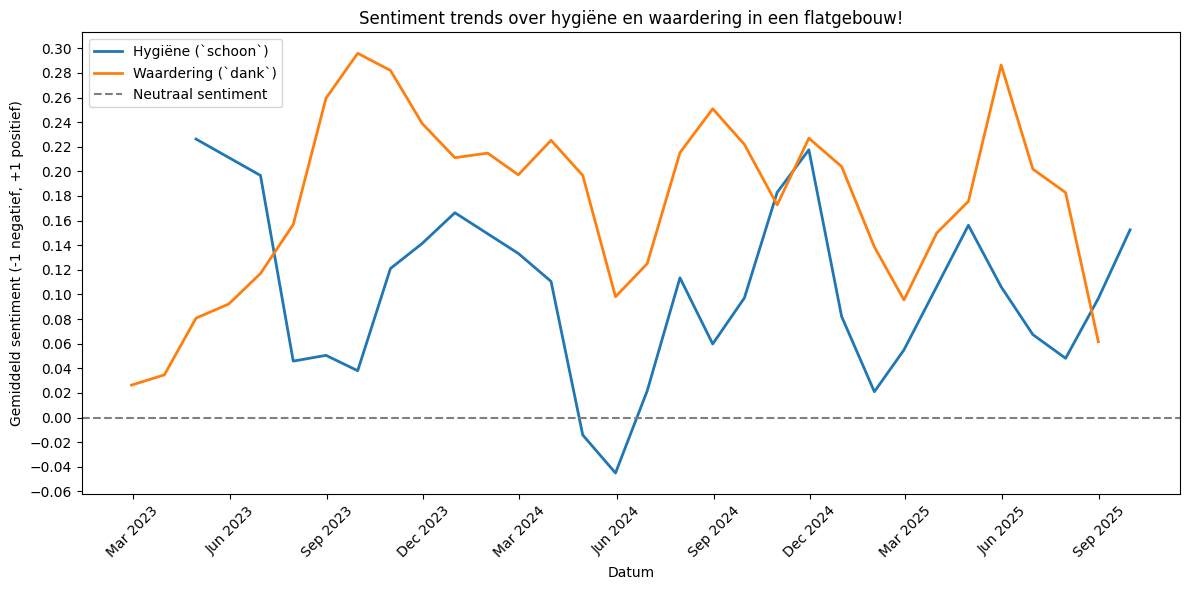

In [35]:
# --- Voorbeeldgebruik ---
keywords = ["schoon", "dank"]
df_keywords = compute_keyword_sentiment_nl(df, keywords)
monthly_sentiment = resample_monthly_sentiment(df_keywords, keywords)
cooccurring_months = filter_cooccurring_months(monthly_sentiment, keywords)
# cooccurring_messages = get_cooccurring_messages(df_keywords, keywords)

plot_cooccurring_keywords_rolling_only(monthly_sentiment, keywords)

# print("Co-occurring messages:")
# print(cooccurring_messages)